# Evaluation on Kang Data

In [1]:
# %load_ext nb_black
%load_ext autoreload
%autoreload 2

# Do not show FutureWarnings
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)

In [2]:
import os
import copy
import pandas as pd
import anndata as ad
import numpy as np
import benchmark as bm
from sklearn.metrics import roc_auc_score
import scanpy as sc
import plotnine as p9
from prismo._core import PRISMO
from prismo._pl import plot_weights
from prismo._core import FeatureSets as fs
from plotting import plot_scores


%matplotlib
%matplotlib inline

# Settings
device = "cuda:1"
seed = 2411111440
rng = np.random.default_rng(seed)

# Plotting
p9.theme_set(p9.theme_bw())
colors_disc = [
    "#FF9999",
    "#66B2FF",
    "#99FF99",
    "#FFCC99",
    "#FF99CC",
    "#99CCFF",
    "#FF6666",
    "#66CC00",
]
colors_div = ["#214D83", "#7D1B26"]  # blue, red

/data/m015k/miniconda3/envs/prismo/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
 captum (see https://github.com/pytorch/captum).


Spectra GPU support is still under development. Raise any issues on github 
 
 Changes from v1: 
 (1) GPU support [see tutorial] 
 (2) minibatching for local parameters and data 
 Note that minibatching may affect optimization results 
 Code will eventually be merged into spectra.py
Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.

Using matplotlib backend: module://matplotlib_inline.backend_inline


## Load data and Reactome pathways

In [3]:
adata = ad.read_h5ad("data/kang_tutorial.h5ad").copy()
adata.var_names = adata.var_names.str.upper()
adata._inplace_subset_var(adata.to_df().std() > 0.2)

gene_set_collection = fs.from_gmt("../msigdb/c2.cp.reactome.v7.5.1.symbols.gmt")
gene_set_collection = gene_set_collection.filter(
    adata.var_names,
    min_fraction=0.4,
    min_count=40,
    max_count=200,
)
true_mask = gene_set_collection.to_mask(adata.var_names.tolist())
terms = true_mask.index.tolist()

# Modify the prior knowledge introducing noise
true_mask_copy = true_mask.copy()
true_mask = true_mask.values
noisy_mask = bm.get_rand_noisy_mask(rng, true_mask, fpr=0.2, fnr=0.2)

### Preprocessing

In [4]:
x = adata.X
x = x - x.min(axis=0)
log_x = np.log1p(x)
log_x = log_x / log_x.std()
log_x_centered = log_x - log_x.mean(axis=0)
log_x_stdised = log_x_centered / log_x_centered.std()

data_dict = {
    "expimap": log_x_centered.astype(np.float32),
    "expimap_nb": x.astype(np.float32),
    "expimap_hardmask": log_x_centered.astype(np.float32),
    "expimap_hardmask_nb": x.astype(np.float32),
    "spectra": log_x.astype(np.float32),
    "prismo": log_x_centered.astype(np.float32),
    "prismo_nmf": log_x.astype(np.float32),
}

# Train all Models

In [5]:
model_dict = {}

### Train Expimap

In [6]:
for soft_mask in [True]:
    for recon_loss in ["mse"]:
        model_name = "expimap"
        if not soft_mask:
            model_name += "_hardmask"
        if recon_loss == "nb":
            model_name += "_nb"
        data_name = data_dict[model_name.split("_")[0]]
        model_dict[model_name] = bm.train_expimap(
            data_name,
            noisy_mask,
            seed=seed,
            terms=terms,
            recon_loss=recon_loss,
            # alpha_l1=alpha_l1,
            n_epochs=1000,
            batch_size=1000,
            soft_mask=soft_mask,
            hidden_size_1=512,
            hidden_size_2=256,
        )


INITIALIZING NEW NETWORK..............
Encoder Architecture:
	Input Layer in, out and cond: 4325 512 1
	Hidden Layer 1 in/out: 512 256
	Mean/Var Layer in/out: 256 120
Decoder Architecture:
	Masked linear layer in, ext_m, ext, cond, out:  120 0 0 1 4325
	with soft mask.
Last Decoder layer: identity
The default value of alpha_kl was changed to 0.35. from 1. This may case inconsistency with previous training results. Set alpha_kl=1. to reproduce the previous results.
alpha_epoch_anneal is used by default now. This may case inconsistency with previous training results. Set alpha_epoch_anneal=None to reproduce the previous results.
Preparing (13576, 4325)
Instantiating dataset
 |███-----------------| 17.4%  - epoch_loss: 1481.2821796124 - epoch_recon_loss: 1421.0615891677 - epoch_kl_loss: 172.0588261531 - val_loss: 1498.7044677734 - val_recon_loss: 1438.1884155273 - val_kl_loss: 172.9029541016
ADJUSTED LR
 |████----------------| 20.9%  - epoch_loss: 1476.7358492338 - epoch_recon_loss: 1416

### Train Sepctra

In [7]:
if os.path.exists("model_dict_spectra.pkl"):
    import pickle

    with open("model_dict_spectra.pkl", "rb") as f:
        model_dict["spectra"] = pickle.load(f)
else:
    model_dict["spectra"] = bm.train_spectra(
        data_dict["spectra"], noisy_mask, terms=terms, num_epochs=10000
    )

### Train PRISMO

In [8]:
for model_name in ["prismo", "prismo_nmf"]:
    prior_penalty = 0.003
    if False & os.path.exists(f"{model_name}.h5"):
        model_dict[model_name] = PRISMO.load(f"{model_name}.h5")
    else:
        model_dict[model_name] = bm.train_prismo(
            data_dict[model_name],
            noisy_mask,
            obs=adata.obs,
            var=adata.var,
            seed=seed,
            terms=terms,
            obs_names=adata.obs_names.copy(),
            var_names=adata.var_names.copy(),
            n_factors=2,
            nmf="nmf" in model_name,
            prior_penalty=prior_penalty,
            max_epochs=5000,
            batch_size=0,
            n_particles=1,
            lr=0.003,
            early_stopper_patience=100,
            device="cuda:1",
            true_mask=true_mask,
            init_factors="random",
            init_scale=0.1,
            save_path=model_name,
            dense_factor_scale=1.0,
        )
        model_dict["prismo_nmf"] = model_dict[model_name]

2024-12-09 15:46:38 | prismo._core.prismo | INFO | Setting up device...
INFO:prismo._core.prismo:Setting up device...
2024-12-09 15:46:39 | prismo._core.prismo | INFO | - Checking compatibility of provided likelihoods with data.
INFO:prismo._core.prismo:- Checking compatibility of provided likelihoods with data.
2024-12-09 15:46:39 | prismo._core.prismo | INFO |   - view_0: Normal
INFO:prismo._core.prismo:  - view_0: Normal
2024-12-09 15:46:39 | prismo._core.prismo | INFO | Initializing factors using `random` method...
INFO:prismo._core.prismo:Initializing factors using `random` method...
2024-12-09 15:46:39 | prismo._core.prismo | INFO | Decaying learning rate over 5000 iterations.
INFO:prismo._core.prismo:Decaying learning rate over 5000 iterations.
2024-12-09 15:46:39 | prismo._core.prismo | INFO | Setting training seed to `2411111440`.
INFO:prismo._core.prismo:Setting training seed to `2411111440`.
2024-12-09 15:46:39 | prismo._core.prismo | INFO | Cleaning parameter store.
INFO:pr

In [9]:
# Representative model for downstream analysis
model = model_dict["prismo"]

# define order of dict keys
model_dict = {
    "expimap": model_dict["expimap"],
    "spectra": model_dict["spectra"],
    "prismo": model_dict["prismo"],
    "prismo_nmf": model_dict["prismo_nmf"],
}

### Compute Metrics

In [10]:
# AUPRC
per_factor_aupr = {}
top = 200
for k, model in model_dict.items():
    per_factor_aupr[k] = bm.get_average_precision(
        true_mask, model, per_factor=True, top=top
    )
    # print(k, bm.get_average_precision(true_mask, model, top=top))

In [11]:
# BINRARY
per_factor_prec = {}
per_factor_rec = {}
per_factor_f1 = {}
threshold = None
opt_thresh_dict = {}
for k, model in model_dict.items():
    prec, rec, f1, opt_thresh = bm.get_binary_scores(
        true_mask, model, threshold=threshold, per_factor=True, top=top, verbose=False
    )
    opt_thresh_dict[k] = opt_thresh
    per_factor_prec[k] = prec
    per_factor_rec[k] = rec
    per_factor_f1[k] = f1
    # print(k, bm.get_binary_scores(true_mask, model, threshold=opt_thresh, top=top))

In [12]:
score_df_dict = {
    "AUC-PR": pd.DataFrame(per_factor_aupr),
    "Precision": pd.DataFrame(per_factor_prec),
    "Recall": pd.DataFrame(per_factor_rec),
    "F1": pd.DataFrame(per_factor_f1),
}

In [13]:
# Rename columns for plotting
score_df_dict_new_names = copy.deepcopy(score_df_dict)
for score_name, score_df in score_df_dict_new_names.items():
    score_df.columns = [
        "Expimap",
        "Spectra",
        "PRISMO",
        "PRISMO$_{NN}$",
    ]

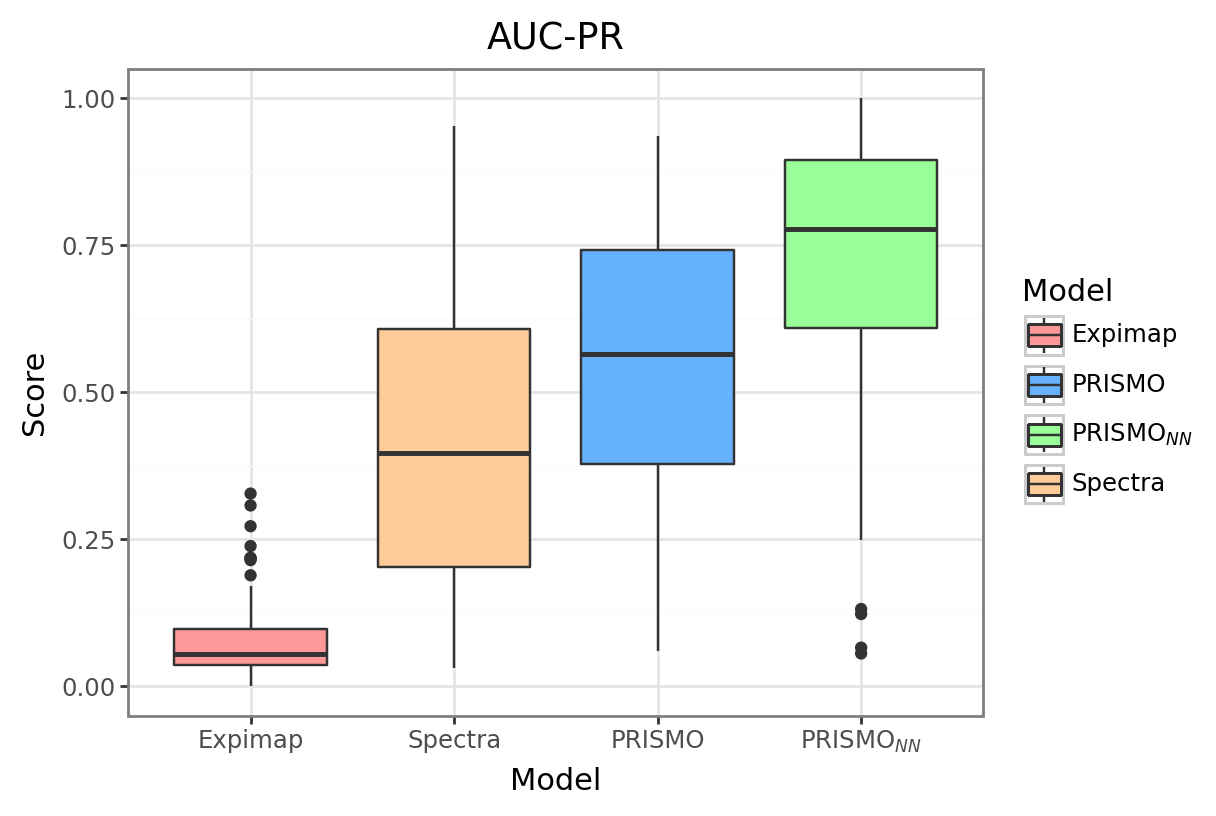

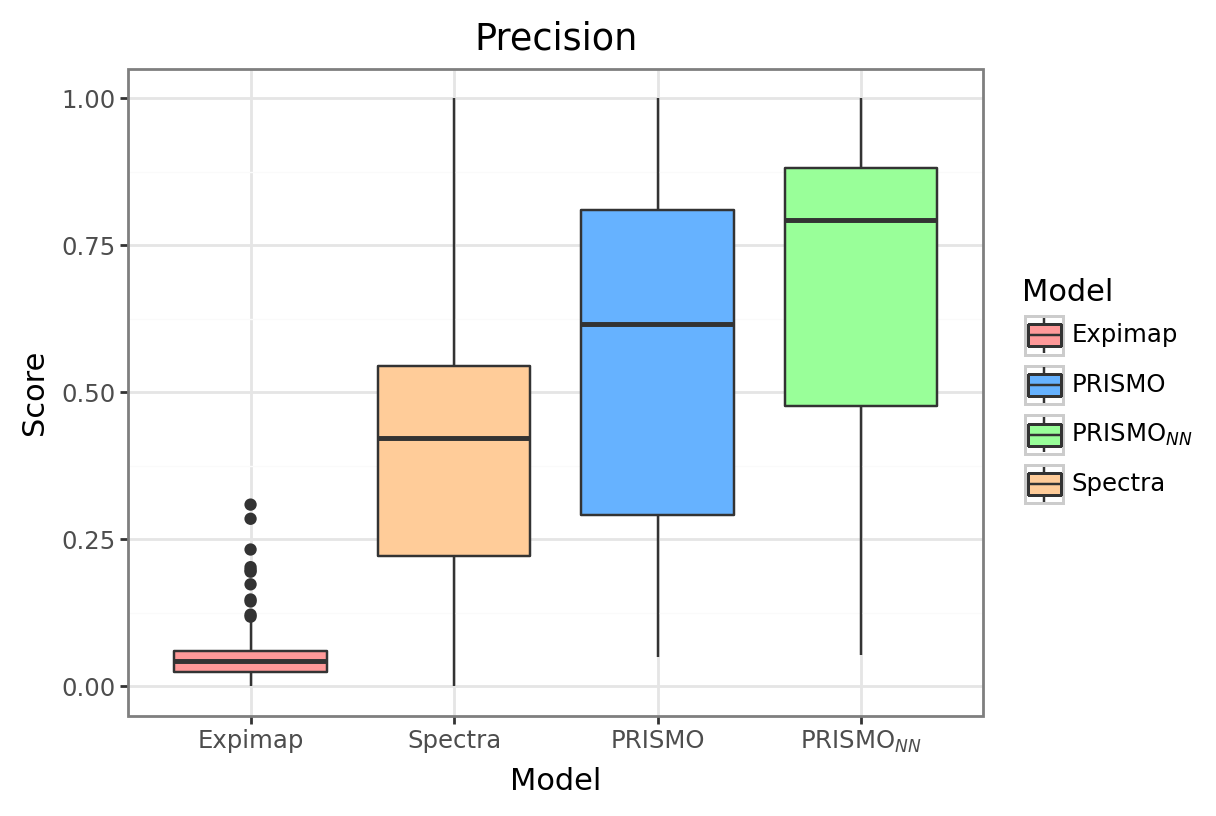

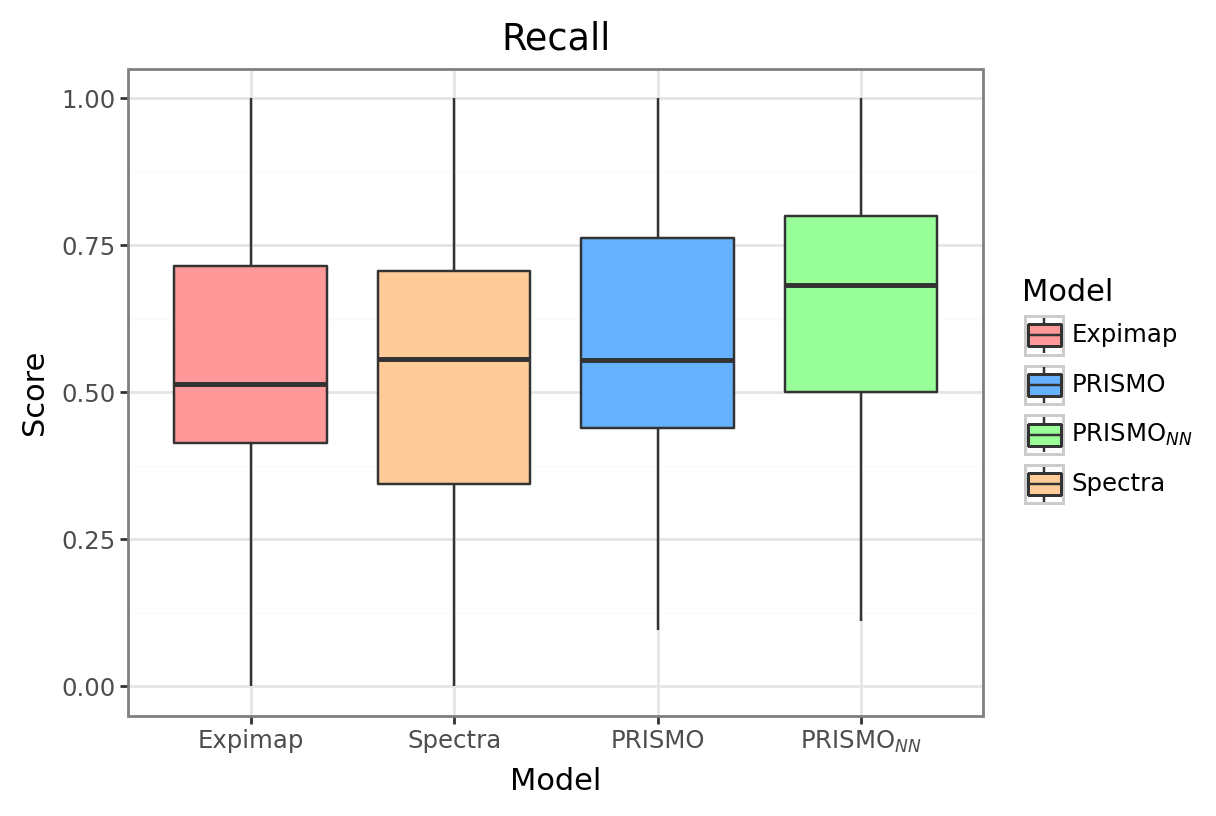

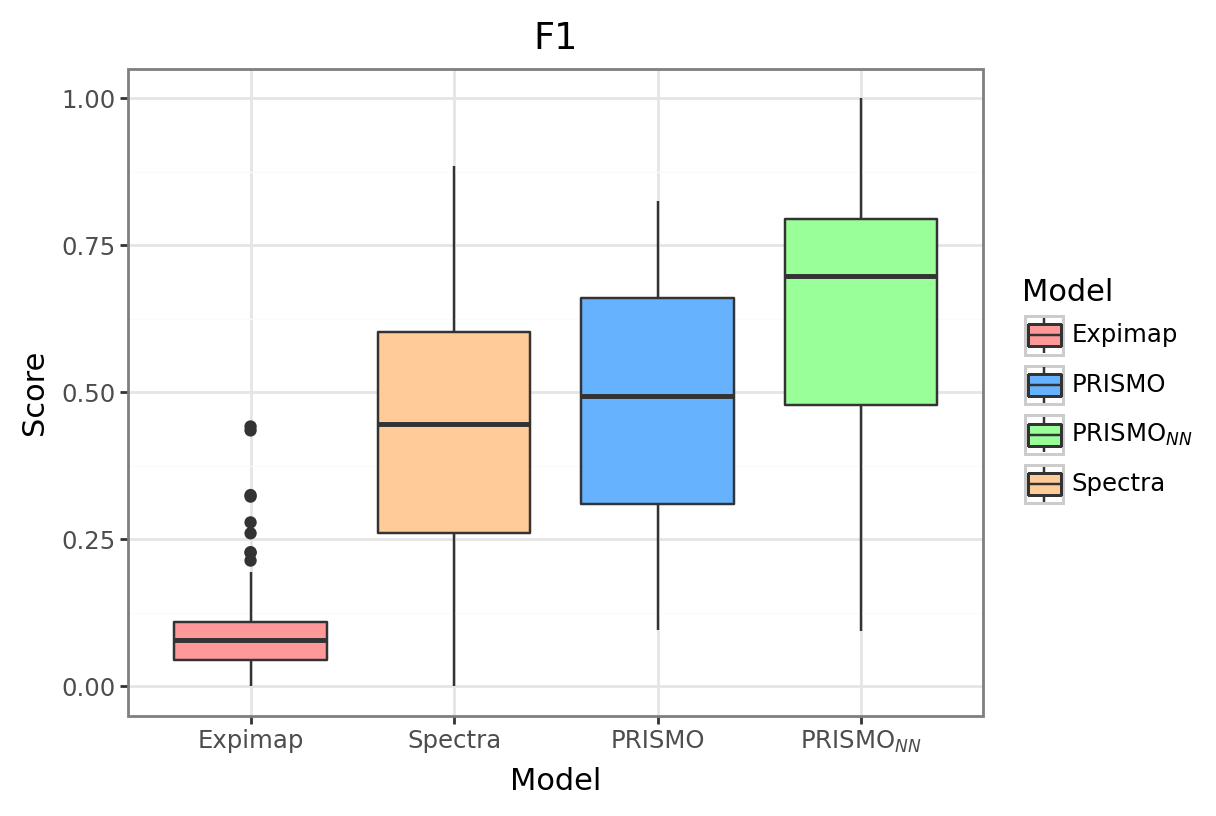

In [14]:
plot_scores(score_df_dict_new_names)

In [15]:
model_scores = {}
for k, model in model_dict.items():
    model_scores[k] = []
    data_name = k.split("-")[0]
    if "expimap" in k:
        data_name = k.split("_")[0]

    data = data_dict[data_name]
    # if "prismo" in k:
    #     data = model.data["group_1"]["view_0"].X
    # model_scores[k].append(bm.get_rmse(model, model.data["group_1"]["view_0"].X))
    model_scores[k].append(bm.get_rmse(model, data))
    # model_scores[k].append(muvi.bm.get_average_precision(true_mask, model, top=200))
    model_scores[k].append(pd.DataFrame(per_factor_aupr).median()[k])

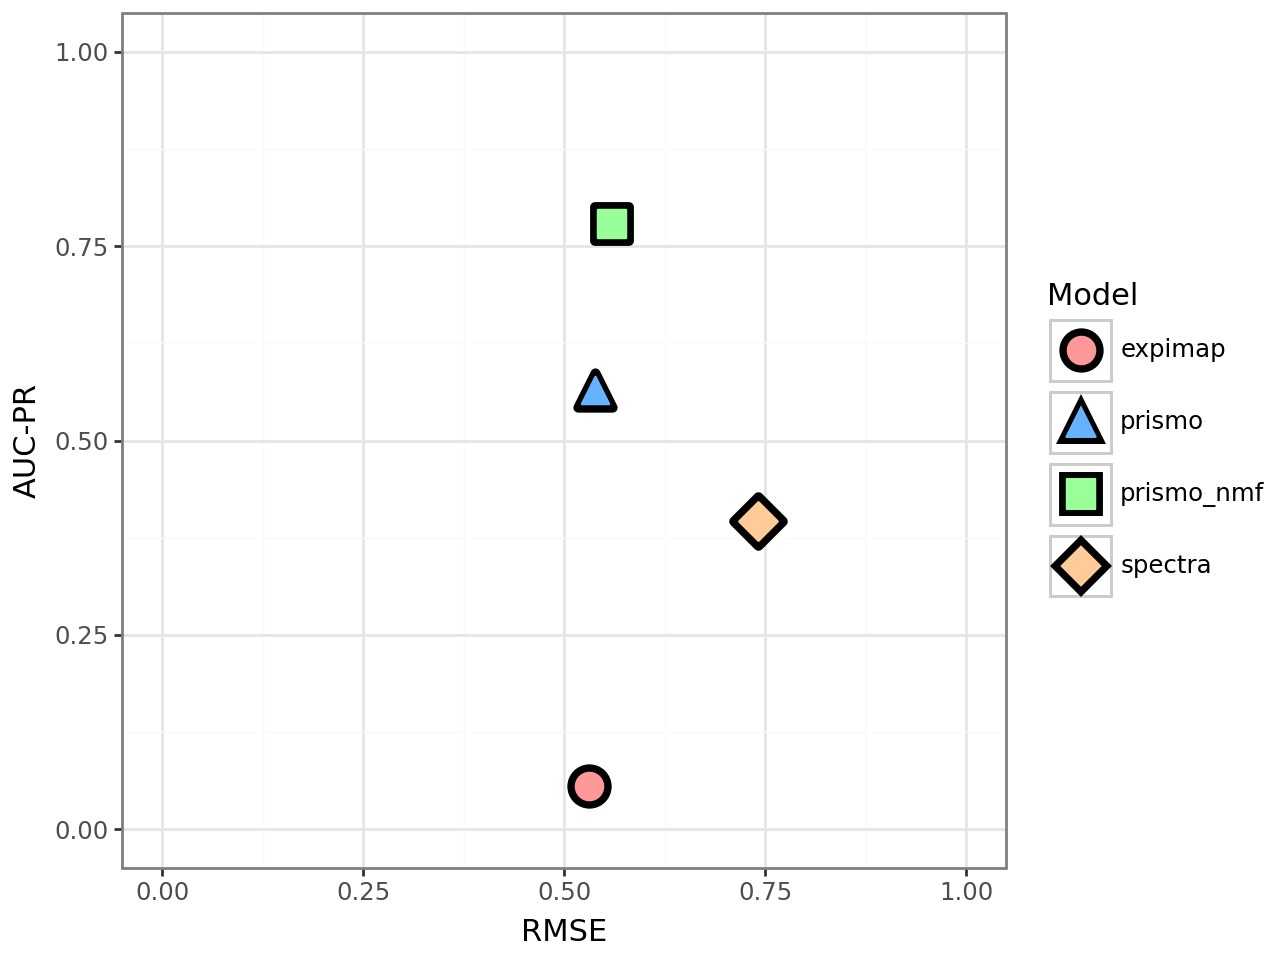

In [16]:
df = pd.DataFrame(model_scores).T.copy()
df.columns = ["RMSE", "AUC-PR"]
df["Model"] = df.index.copy()

plot = (
    p9.ggplot(df, p9.aes(x="RMSE", y="AUC-PR", color="Model", shape="Model"))
    + p9.geom_point(size=5, stroke=2, color="black", fill=None)
    + p9.geom_point(size=5)
    + p9.scale_color_manual(values=colors_disc)
    + p9.xlim(0.0, 1.0)
    + p9.ylim(0.0, 1.0)
    + p9.theme(legend_position="right")
)
plot

In [17]:
factor_loadings = {k: bm.get_factor_loadings(model) for k, model in model_dict.items()}
fn_sum = (true_mask & ~noisy_mask).sum(axis=1)

np.set_printoptions(precision=1)

In [18]:
idx_df = {}
tp_df = {}
tn_df = {}
fp_df = {}
fn_df = {}
for k, model in model_dict.items():
    idx, wh, tm, nm = bm.get_reconstruction_fraction(
        true_mask, noisy_mask, model, top=200
    )
    idx_df[k] = idx
    non_zero = np.abs(wh) > 0.0
    tp = tm & nm & non_zero
    tn = ~tm & ~nm & non_zero
    fp = ~tm & nm & non_zero
    fn = tm & ~nm & non_zero
    tp_df[k] = tp.sum(axis=1).tolist()
    tn_df[k] = tn.sum(axis=1).tolist()
    fp_df[k] = fp.sum(axis=1).tolist()
    fn_df[k] = fn.sum(axis=1).tolist()
tp_df = pd.DataFrame(tp_df)
tn_df = pd.DataFrame(tn_df)
fp_df = pd.DataFrame(fp_df)
fn_df = pd.DataFrame(fn_df)

/data/m015k/miniconda3/envs/prismo/lib/python3.12/site-packages/plotnine/scales/scales.py:48: PlotnineWarning: Scale for 'x' is already present.
Adding another scale for 'x',
which will replace the existing scale.



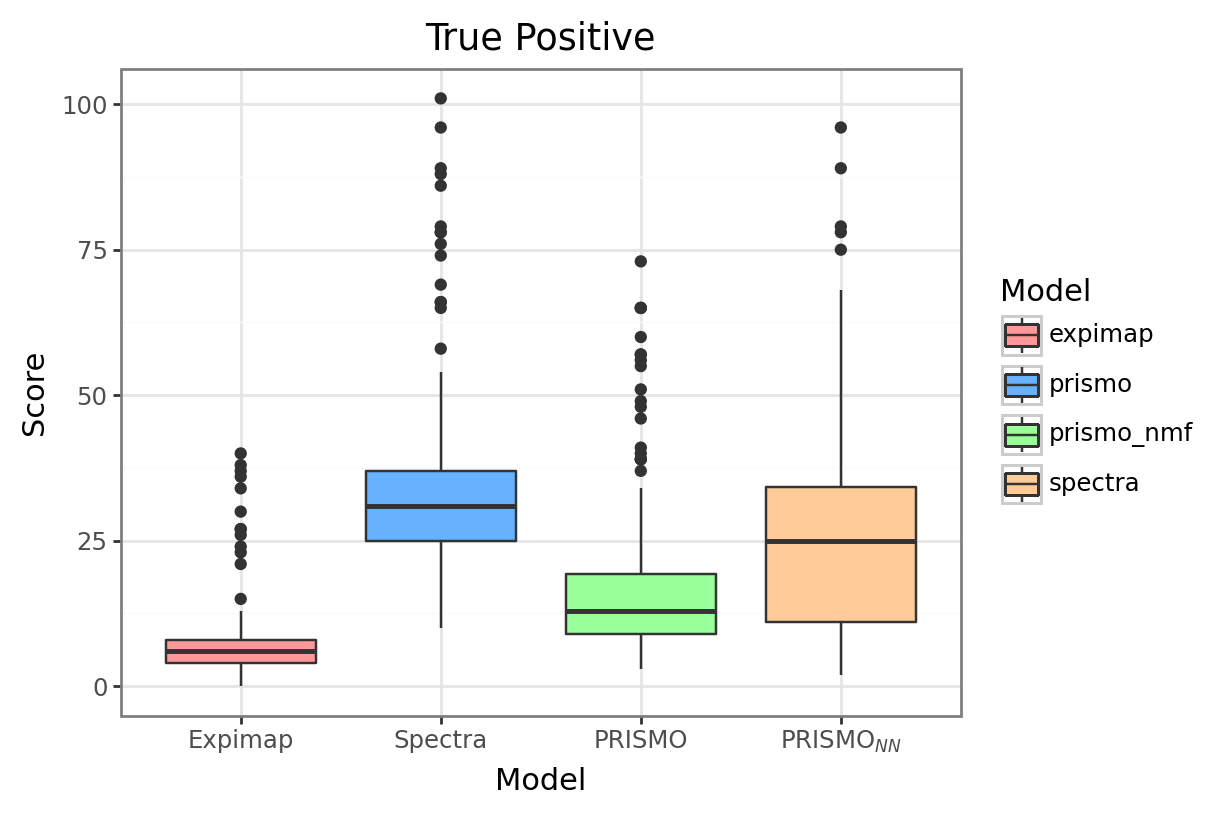

/data/m015k/miniconda3/envs/prismo/lib/python3.12/site-packages/plotnine/scales/scales.py:48: PlotnineWarning: Scale for 'x' is already present.
Adding another scale for 'x',
which will replace the existing scale.



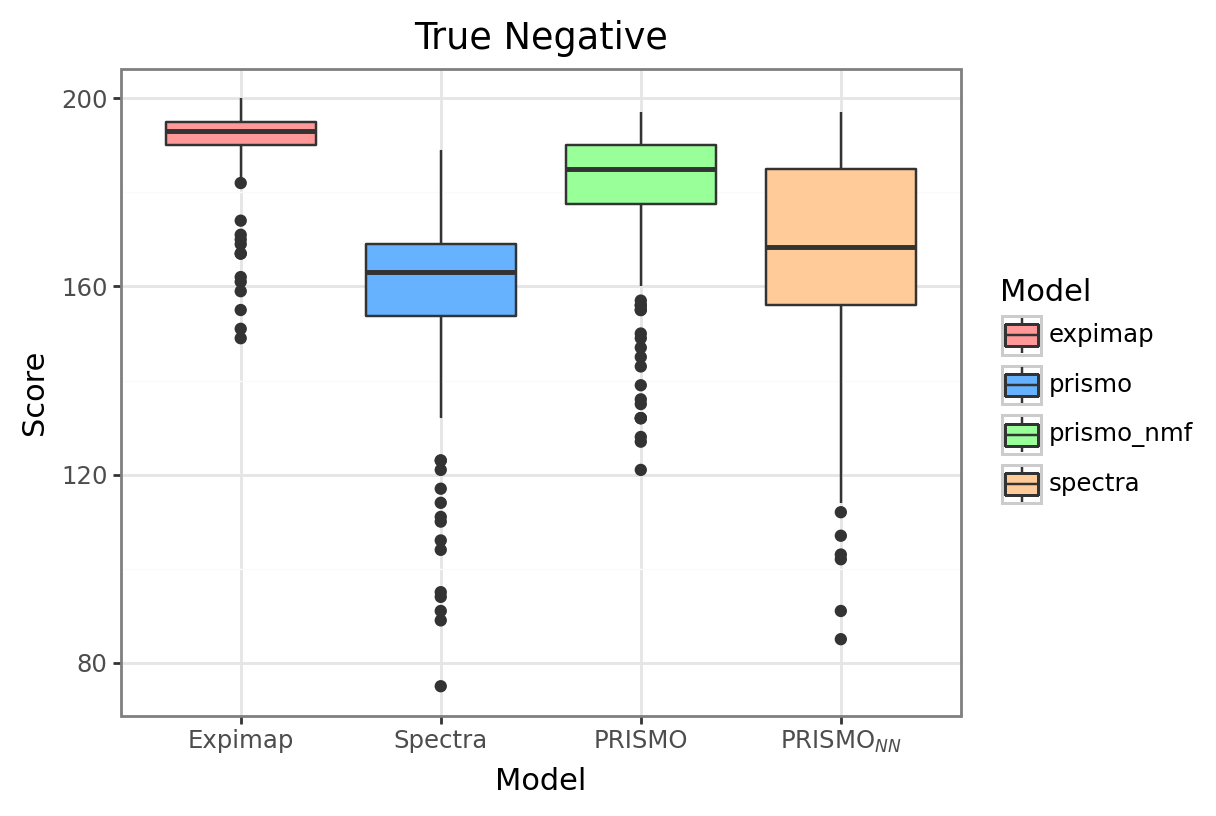

/data/m015k/miniconda3/envs/prismo/lib/python3.12/site-packages/plotnine/scales/scales.py:48: PlotnineWarning: Scale for 'x' is already present.
Adding another scale for 'x',
which will replace the existing scale.



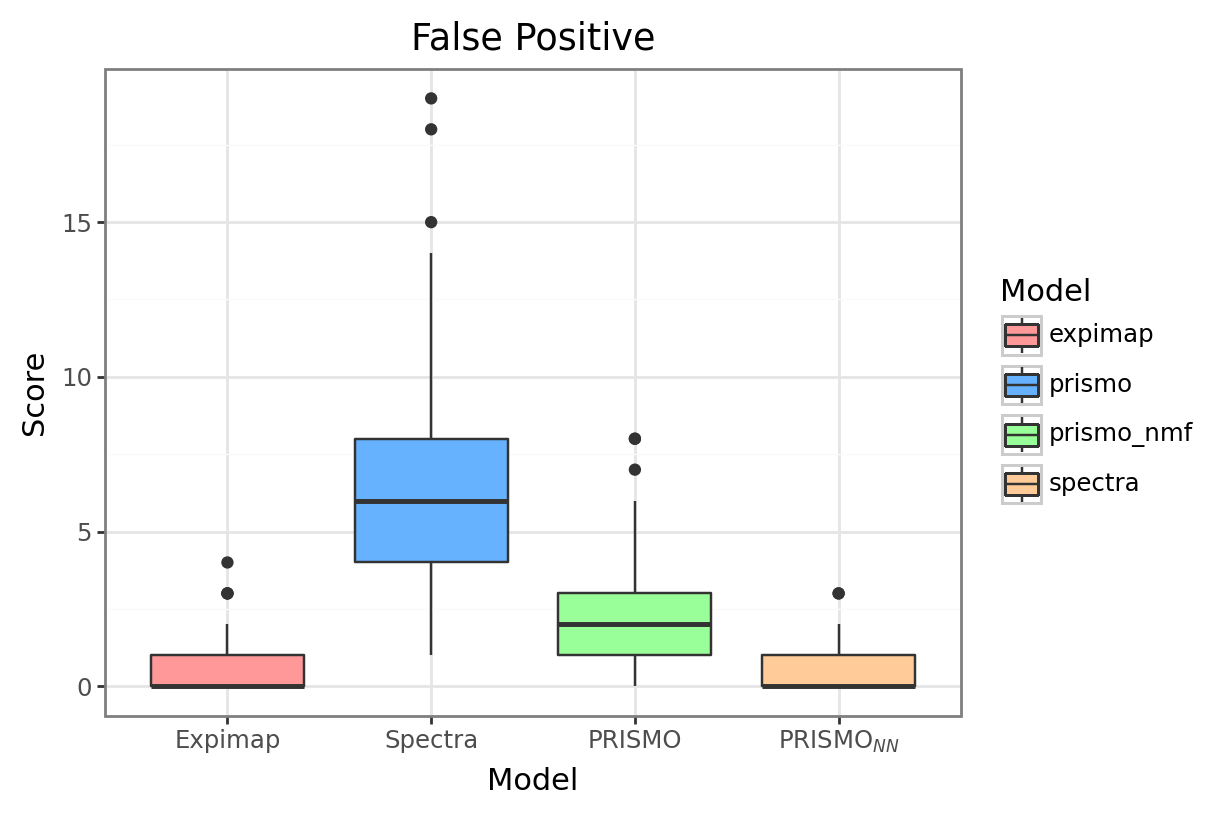

/data/m015k/miniconda3/envs/prismo/lib/python3.12/site-packages/plotnine/scales/scales.py:48: PlotnineWarning: Scale for 'x' is already present.
Adding another scale for 'x',
which will replace the existing scale.



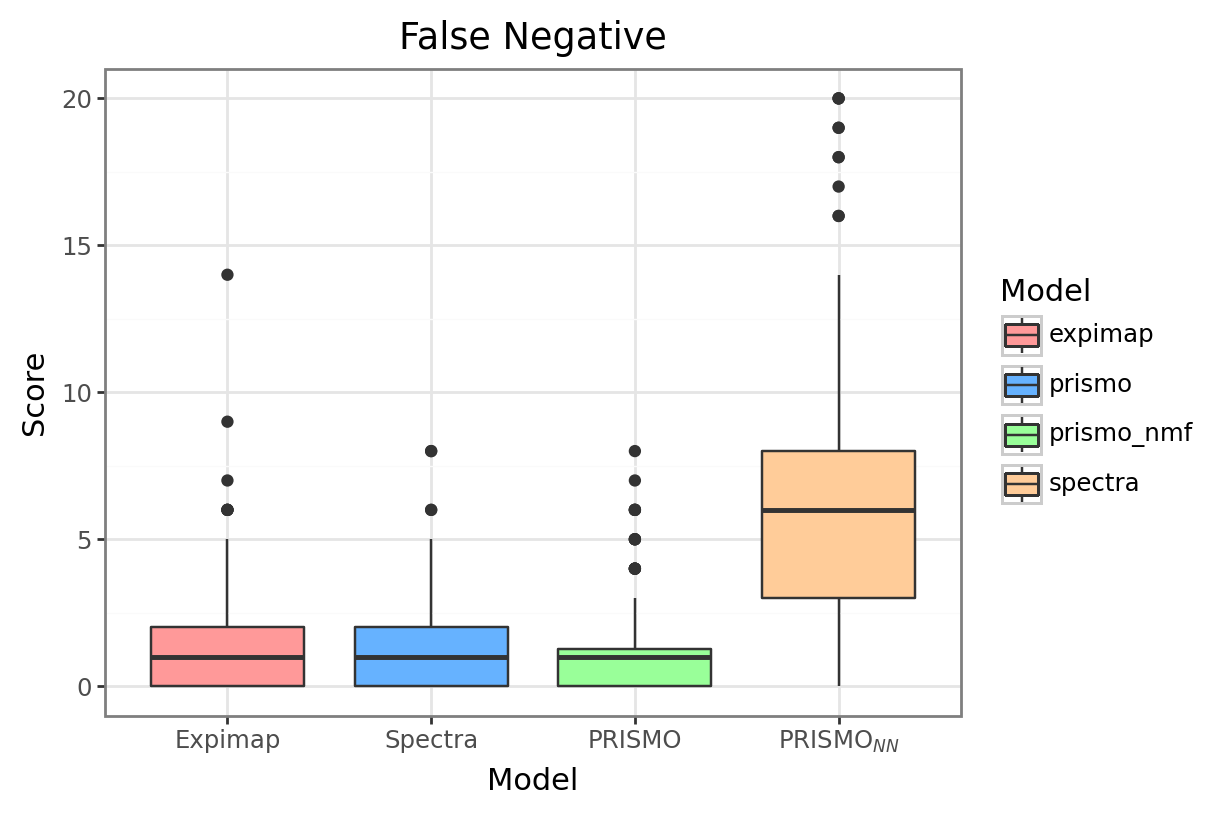

In [19]:
model_names = ["expimap", "spectra", "prismo", "prismo_nmf"]
model_labels = ["Expimap", "Spectra", "PRISMO", "PRISMO$_{NN}$"]

plot_scores(
    {
        "True Positive": tp_df,
        "True Negative": tn_df,
        "False Positive": fp_df,
        "False Negative": fn_df,
    },
    model_names,
    model_labels,
)

/data/m015k/miniconda3/envs/prismo/lib/python3.12/site-packages/plotnine/geoms/geom_path.py:99: PlotnineWarning: geom_path: Removed 1 rows containing missing values.
/data/m015k/miniconda3/envs/prismo/lib/python3.12/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 120 rows containing missing values.


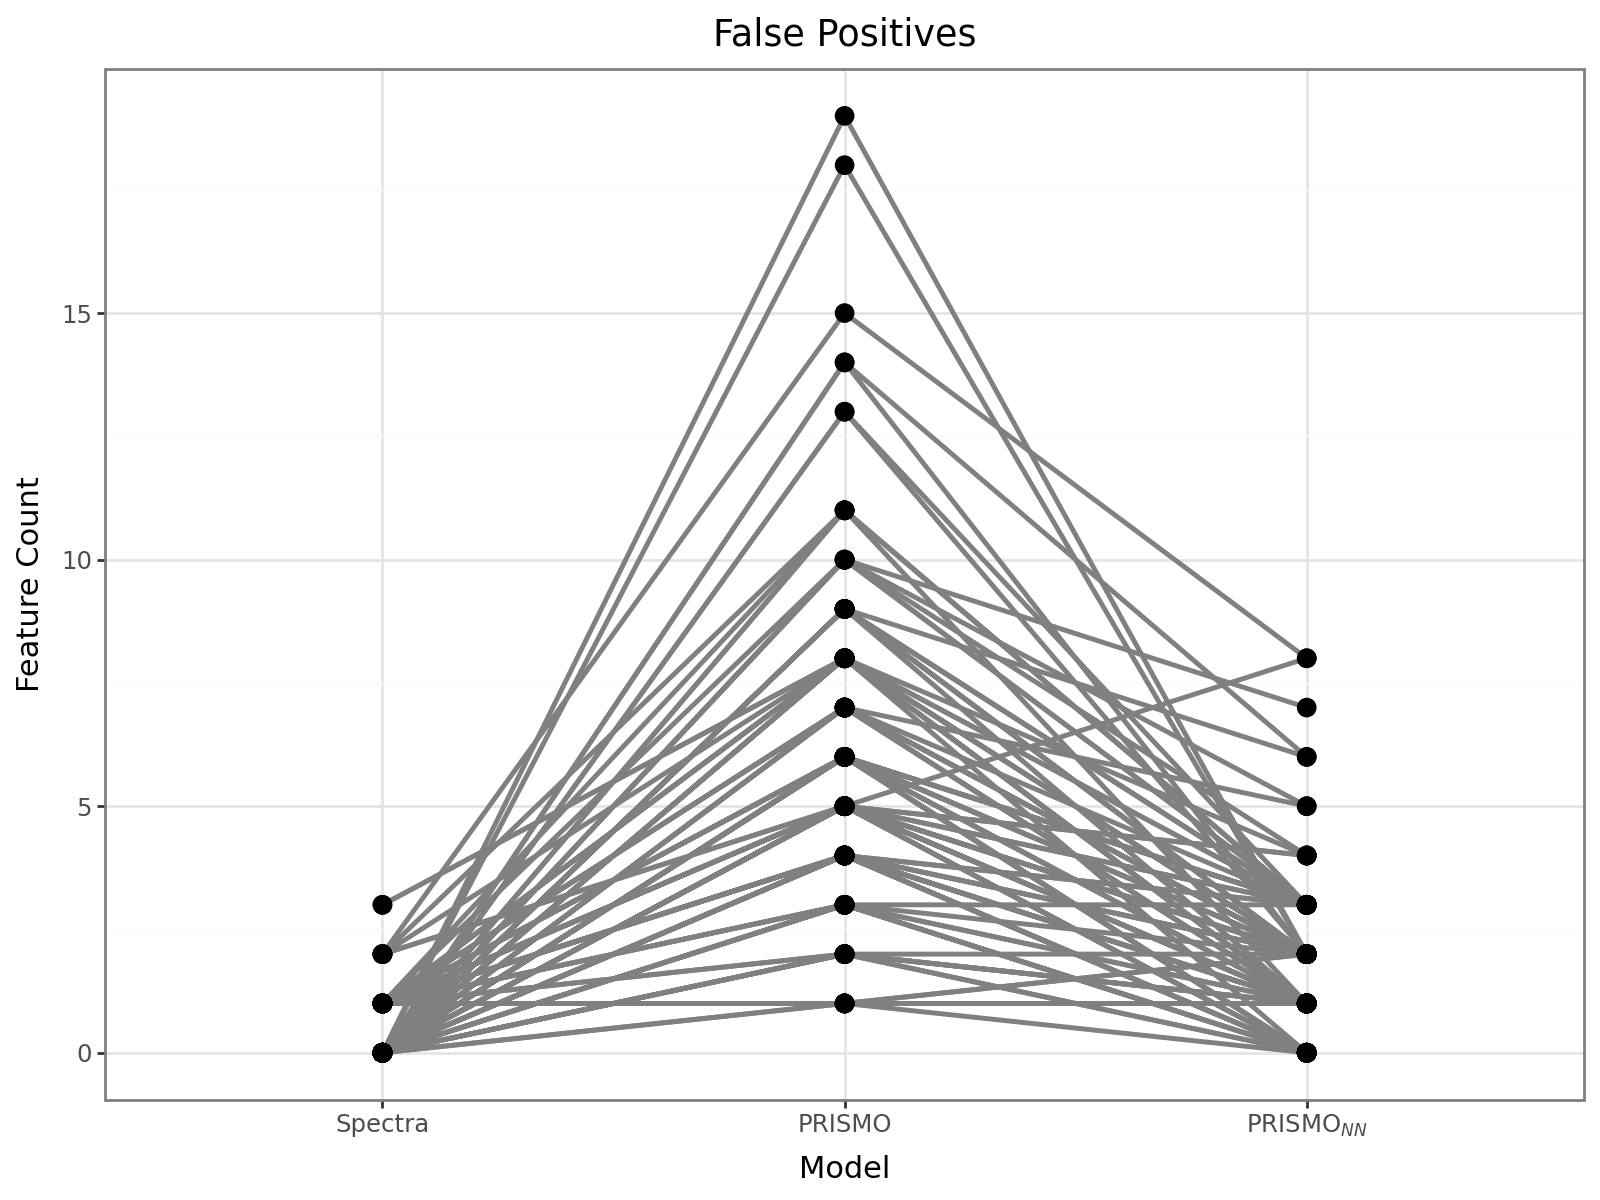

In [20]:
model_cols = model_names
point_df = fp_df[model_cols].copy()
model_cols = model_labels

point_df.columns = model_cols
point_df["factor"] = point_df.index.copy()
point_df = pd.melt(
    point_df,
    id_vars=["factor"],
    value_vars=model_cols,
    var_name="Model",
    value_name="Feature Count",
)

(
    p9.ggplot(point_df, p9.aes(x="Model", y="Feature Count", group="factor"))
    + p9.geom_line(alpha=1.0, color="gray", size=1)
    + p9.geom_point(alpha=1.0, color="black", size=3)
    + p9.ggtitle("False Positives")
    + p9.theme(figure_size=(8, 6))
    + p9.scale_x_discrete(
        limits=[
            "Spectra",
            "PRISMO",
            "PRISMO$_{NN}$",
        ]
    )
)

/data/m015k/miniconda3/envs/prismo/lib/python3.12/site-packages/plotnine/geoms/geom_path.py:99: PlotnineWarning: geom_path: Removed 1 rows containing missing values.
/data/m015k/miniconda3/envs/prismo/lib/python3.12/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 120 rows containing missing values.


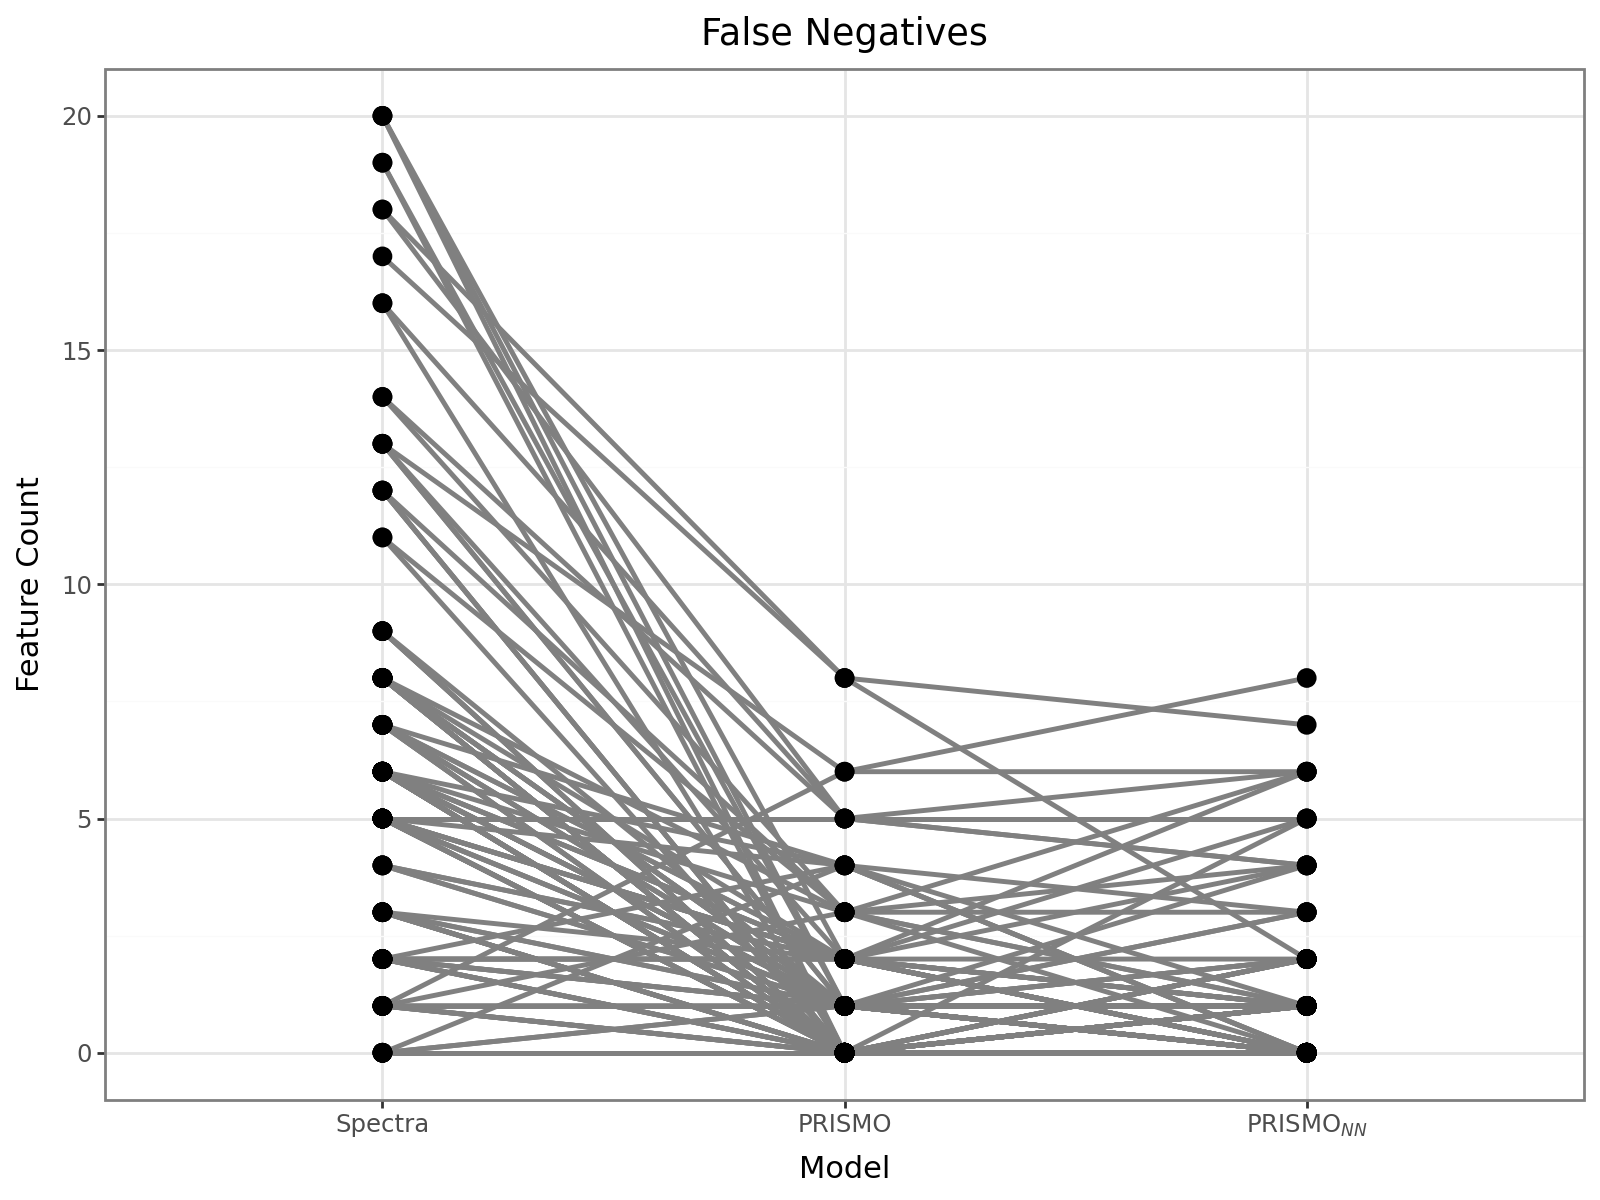

In [21]:
model_cols = model_names
point_df = fn_df[model_cols].copy()
model_cols = model_labels

point_df.columns = model_cols
point_df["factor"] = point_df.index.copy()
point_df = pd.melt(
    point_df,
    id_vars=["factor"],
    value_vars=model_cols,
    var_name="Model",
    value_name="Feature Count",
)

(
    p9.ggplot(point_df, p9.aes(x="Model", y="Feature Count", group="factor"))
    + p9.geom_line(alpha=1.0, color="gray", size=1)
    + p9.geom_point(alpha=1.0, color="black", size=3)
    + p9.ggtitle("False Negatives")
    + p9.theme(figure_size=(8, 6))
    + p9.scale_x_discrete(
        limits=[
            "Spectra",
            "PRISMO",
            "PRISMO$_{NN}$",
        ]
    )
)